In [6]:
!pip install kerassurgeon
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import load_model
from kerassurgeon import identify 
from kerassurgeon.operations import delete_channels,delete_layer
from kerassurgeon import Surgeon

In [0]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

def normalize(x_train,x_test):
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)
    return x_train, x_test


x_train , x_test = normalize(x_train,x_test)

y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)


In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



model_1 = Sequential()

model_1.add(Conv2D(32,(3,3),activation='relu',input_shape=x_train.shape[1:]))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(32,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(64,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(10,activation='softmax'))

model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), padding='same',activation='relu',
                 input_shape=x_train.shape[1:]))

model_2.add(Conv2D(32, (3, 3),activation='relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same',activation='relu'))

model_2.add(Conv2D(64, (3, 3),activation='relu',))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512,activation='relu',))

model_2.add(Dropout(0.5))
model_2.add(Dense(10,activation='softmax',))


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
my_model = model_1
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

In [10]:
my_model = load_model('drive/My Drive/Colab Notebooks/model1_before_pruning.h5')
score_train = my_model.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = my_model.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


50000/50000 [==============================] - 23s 450us/step
Accuracy on the Train Images:  0.73128
10000/10000 [==============================] - 4s 434us/step
Accuracy on the Test Images:  0.6894


In [84]:
def my_get_all_conv_layers(model,first_time):
    all_conv_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:6] == 'conv2d'):
            all_conv_layers.append(i)

    return all_conv_layers if (first_time==True) else all_conv_layers[1:]

def my_get_all_dense_layers(model):
    all_dense_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:5] == 'dense'):
            all_dense_layers.append(i)
    return all_dense_layers


all_dense_layers = my_get_all_dense_layers(my_model)

all_conv_layers = my_get_all_conv_layers(my_model)

print('All convolution layers = ',all_conv_layers,'\nAll dense layers = ',all_dense_layers)


TypeError: ignored

In [0]:
def my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,graph,first_time):
    weights = list()
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    for i in all_conv_layers:
        print('{}th layer'.format(i),all_conv_layers)
        weights.append(model.layers[i].get_weights()[0])
    layer_wise_filter_sorted_indices = list()
    layer_wise_filter_sorted_values = list()
    for i in range(len(weights)):
        weight = weights[i]
        num_filters = len(weight[0,0,0,:])
        # print(num_filters)
        weights_dict = dict() 
        for j in range(num_filters):
            weights_sum = np.sum(abs(weight[:,:,:,j]))
            filtr = 'filter {}'.format(j)
            weights_dict[filtr] = weights_sum
        
        weights_dict_sorted = sorted(weights_dict.items(),key = lambda kv:kv[1]) 
        # print('L1 norm of conv2D_{} layer'.format(i+1),weights_dict_sorted)

        weight_values = list()
        filter_indices = list()

        for element in weights_dict_sorted:
            filter_indices.append(int(element[0][6:]))  # extracting the index of filter from string (tentative try to come up with better code)
            weight_values.append(element[1]) 
    
        layer_wise_filter_sorted_indices.append(filter_indices)
        layer_wise_filter_sorted_values.append(weight_values)

        if graph == True:
                x = np.arange(num_filters)
                plt.figure(i+1,figsize=(7,5))
                plt.plot(x,np.array(weight_values))
                plt.axhline(y=np.mean(np.array(weight_values)),c='r')
                for j in range(len(layer_wise_filter_sorted_values[i])):
                    if(np.mean(np.array(weight_values)) < weight_values[j]):
                        plt.axvline(x=j,c='r')
                        break

                plt.xlabel('filter number')
                plt.ylabel('L1 norm')
                plt.title('Conv2d_{}'.format(i+1))
                plt.grid(True)
                plt.style.use(['classic'])
    return layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values

In [92]:
def my_get_prune_filter_indices(model,first_time ):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model, False,first_time)
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    thresh_hold_means = list()
    for i in range(len(all_conv_layers)):
        # print(i,'/',len(all_conv_layers))
        thresh_hold_means.append(np.mean(np.array(layer_wise_filter_sorted_values[i])))
    prune_filter_indices = list()
    for i in range(len(all_conv_layers)):
        for j in range(len(layer_wise_filter_sorted_values[i])):
            if(thresh_hold_means[i] < layer_wise_filter_sorted_values[i][j]):
                prune_filter_indices.append(j)
                break
    return prune_filter_indices
prune_filter_indices = my_get_prune_filter_indices(my_model,True)
prune_filter_indices

0th layer [0, 2, 4]
2th layer [0, 2, 4]
4th layer [0, 2, 4]


[17, 11, 18]

In [0]:
def my_delete_filters(model,first_time):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,False,first_time)
    prune_filter_indices = my_get_prune_filter_indices(model,first_time)
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    print(all_conv_layers)
    surgeon = Surgeon(my_model)
    for index,value in enumerate(all_conv_layers):
        print(value,index,prune_filter_indices[index])
        surgeon.add_job('delete_channels',model.layers[value],channels = layer_wise_filter_sorted_indices[index][0:prune_filter_indices[index]])
    model_new = surgeon.operate()
    return model_new


In [142]:
m = my_delete_filters(my_model,first_time = True)

0th layer [0, 2, 4]
2th layer [0, 2, 4]
4th layer [0, 2, 4]
0th layer [0, 2, 4]
2th layer [0, 2, 4]
4th layer [0, 2, 4]
[0, 2, 4]
0 0 17
2 1 11
4 2 18
Deleting 17/32 channels from layer: conv2d_1
Deleting 11/32 channels from layer: conv2d_2
Deleting 18/64 channels from layer: conv2d_3


In [17]:
model_new = load_model('drive/My Drive/Colab Notebooks/model1_just_after_pruning.h5')
model_new.summary()
print(my_get_all_conv_layers(model_new))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 15)        420       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 21)        2856      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 21)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 46)          8740      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 46)          0   

In [0]:
# surgeon = Surgeon(model_new)
# surgeon.add_job('delete_channels',model_new.layers[1],channels = np.arange(5))
# surgeon.add_job('delete_channels',model_new.layers[3],channels = np.arange(5))
# model_new = surgeon.operate()
# print(my_get_all_conv_layers(model_new,False))

In [19]:
model_new.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 15)        420       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 21)        2856      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 21)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 46)          8740      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 46)          0   

In [20]:



score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])


50000/50000 [==============================] - 22s 442us/step
Accuracy on the Train Images:  0.22772
10000/10000 [==============================] - 4s 439us/step
Accuracy on the Test Images:  0.2183


In [136]:
model_new = load_model('drive/My Drive/Colab Notebooks/model1_after_training_pruned_model.h5')

score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])



50000/50000 [==============================] - 23s 456us/step
Accuracy on the Train Images:  0.73522
10000/10000 [==============================] - 4s 435us/step
Accuracy on the Test Images:  0.6834


In [143]:
model1 = my_delete_filters(my_model,True)

0th layer [0, 2, 4]
2th layer [0, 2, 4]
4th layer [0, 2, 4]
0th layer [0, 2, 4]
2th layer [0, 2, 4]
4th layer [0, 2, 4]
[0, 2, 4]
0 0 17
2 1 11
4 2 18
Deleting 17/32 channels from layer: conv2d_1
Deleting 11/32 channels from layer: conv2d_2
Deleting 18/64 channels from layer: conv2d_3


In [147]:
my_get_all_conv_layers(model1,False)

# model2 = my_delete_filters(model1,False) 

# my_get_all_conv_layers(model_new,False)
# model_new.summary()
# a,b = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model_new,graph = False,first_time = False)
# for i in a:
#     print(i)
# 

[1, 3, 5]

1th layer [1, 3, 5]
3th layer [1, 3, 5]
5th layer [1, 3, 5]


([[8, 12, 4, 14, 7, 1, 0, 3, 2, 13, 5, 11, 10, 6, 9],
  [17, 5, 12, 8, 0, 11, 9, 16, 4, 18, 10, 3, 13, 14, 19, 2, 20, 15, 1, 7, 6],
  [30,
   23,
   11,
   43,
   25,
   26,
   18,
   4,
   42,
   3,
   14,
   2,
   15,
   34,
   13,
   22,
   37,
   0,
   6,
   35,
   45,
   20,
   21,
   7,
   1,
   44,
   8,
   27,
   39,
   5,
   38,
   32,
   31,
   40,
   16,
   29,
   28,
   24,
   33,
   41,
   10,
   17,
   36,
   19,
   9,
   12]],
 [[3.6442065,
   3.7889051,
   3.8048155,
   3.8212209,
   3.8496473,
   3.8770027,
   3.941349,
   3.945002,
   3.9666975,
   4.072291,
   4.259786,
   4.3048205,
   4.353953,
   4.449021,
   5.165729],
  [16.105381,
   16.457289,
   16.887762,
   16.898977,
   17.147526,
   17.164097,
   17.21782,
   17.76977,
   17.943779,
   18.13654,
   18.478115,
   18.656748,
   18.845135,
   18.893162,
   18.930674,
   19.38805,
   20.365082,
   20.483078,
   20.578724,
   20.594906,
   20.622889],
  [19.592834,
   19.708635,
   19.742218,
   19.857868,
   

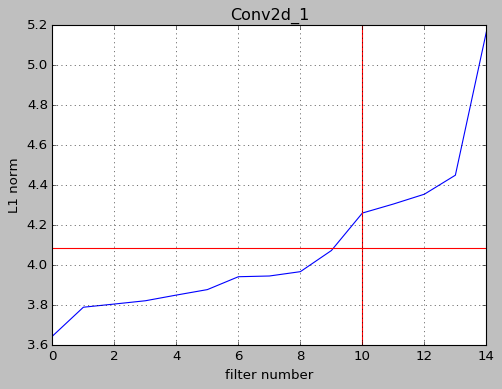

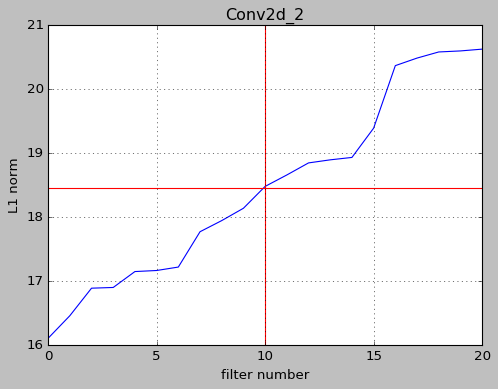

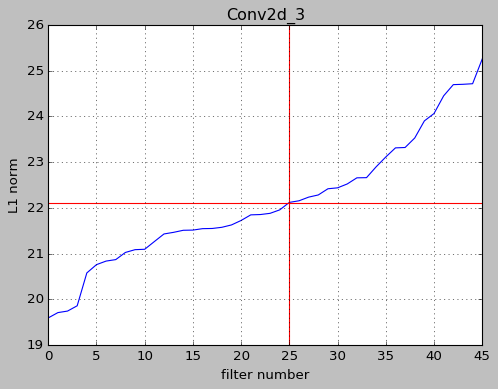

In [149]:
my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model1,graph=True,first_time = False)

In [150]:
my_get_prune_filter_indices(model1,False)

1th layer [1, 3, 5]
3th layer [1, 3, 5]
5th layer [1, 3, 5]


[10, 10, 25]

In [161]:

surgeon = Surgeon(model1)
surgeon.add_job('delete_channels',model1.layers[1],channels = np.arange(5))
model2 = surgeon.operate()
model2.summary()
print(model1.layers[1].name,model1.layers[3].name,model1.layers[5].name)

Deleting 5/15 channels from layer: conv2d_1
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 21)        1911      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 46)          8740      
_________________________________________________________________
max_pooling2d_

In [164]:
my_delete_filters(model1,False)

1th layer [1, 3, 5]
3th layer [1, 3, 5]
5th layer [1, 3, 5]
1th layer [1, 3, 5]
3th layer [1, 3, 5]
5th layer [1, 3, 5]
[1, 3, 5]
1 0 10
3 1 10
5 2 25


1th layer [1, 3, 5]
3th layer [1, 3, 5]
5th layer [1, 3, 5]
1th layer [1, 3, 5]
3th layer [1, 3, 5]
5th layer [1, 3, 5]


Deleting 10/15 channels from layer: conv2d_1
Deleting 10/21 channels from layer: conv2d_2
Deleting 25/46 channels from layer: conv2d_3


In [180]:

model= load_model('drive/My Drive/Colab Notebooks/model1_before_pruning.h5')


validation_accuracy = model.evaluate(x_test,y_test)[1]
print(validation_accuracy)
max_val_acc = validation_accuracy
count = 0
while max_val_acc <= validation_accuracy:
    print(count)
    if max_val_acc < validation_accuracy:
        max_val_acc = validation_accuracy

    if count < 1:
        model = my_delete_filters(my_model,True)
        
    else:
        conv_layers = my_get_all_conv_layers(model1,False)
        a,b = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model1,False,False)
        thresholds = my_get_prune_filter_indices(model1,False)
        
        surgeon = Surgeon(model)
        for index,value in enumerate(conv_layers):
            # print(value,index,prune_filter_indices[index])
            surgeon.add_job('delete_channels',model.layers[value],channels = a[index][0:thresholds[index]])
        model = surgeon.operate()

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2, shuffle=True)
    validation_accuracy = model.evaluate(x_test,y_test)[1]
    print("--->",validation_accuracy)
    count+=1

10000/10000 [==============================] - 6s 569us/step
0.6894
0
0th layer [0, 2, 4]
2th layer [0, 2, 4]
4th layer [0, 2, 4]
0th layer [0, 2, 4]
2th layer [0, 2, 4]
4th layer [0, 2, 4]
[0, 2, 4]
0 0 17
2 1 11
4 2 18
Deleting 17/32 channels from layer: conv2d_1
Deleting 11/32 channels from layer: conv2d_2
Deleting 18/64 channels from layer: conv2d_3
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 45s 1ms/step - loss: 1.0077 - acc: 0.6486 - val_loss: 0.9532 - val_acc: 0.6735
Epoch 2/10
40000/40000 [==============================] - 41s 1ms/step - loss: 0.8793 - acc: 0.6952 - val_loss: 0.9358 - val_acc: 0.6731
Epoch 3/10
40000/40000 [==============================] - 40s 1ms/step - loss: 0.8377 - acc: 0.7087 - val_loss: 0.9458 - val_acc: 0.6749
Epoch 4/10
40000/40000 [==============================] - 41s 1ms/step - loss: 0.8137 - acc: 0.7175 - val_loss: 0.9297 - val_acc: 0.6748
Epoch 5/10
40000/40000 [======================

In [181]:
model.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 5)         140       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 11)        506       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 21)          2100      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0  

In [175]:
model.evaluate(x_test,y_test)

10000/10000 [==============================] - 4s 354us/step


[1.3905065649032593, 0.5111]